The following was requested:

1. We take the same original picture for all attempts.
2. We take the same "noisy picture" for all attempts - and we give it MSE and SSIM score.
3. We denoise with original "float" - give MSE and SSIM.
4. We denoise with all types of quantization that you tried and give MSE and SSIM.
5. Please give a conclusion in the end - if some types of quantization are better than others.


In [1]:
%matplotlib notebook

import argparse
import time
import os


In [2]:

import matplotlib.pyplot as plt
from data import NoisyBSDSDataset
from argument import Args
from model import DnCNN, UDnCNN, DUDnCNN, QDUDnCNN
import nntools as nt
#from utils import DenoisingStatsManager, plot, NoisyBSDSDataset
import utils
import utils2
from skimage import metrics

import cv2
import numpy as np
import torch


In [3]:

import torch.utils.data as td
import torch.quantization.quantize_fx as quantize_fx
from torch.quantization.fuse_modules import fuse_known_modules
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import model
import inference
from prettytable import PrettyTable

In [4]:
def main(img_set,model_path,qat=False,quantize='none'):
    args = Args()
    args.quantize = quantize
    device = 'cpu'
    if qat:
        denoise, qat_state = inference.load_model(model_path, QDUDnCNN, args.D, args.C, device=device)
    else:
        denoise, qat_state = inference.load_model(model_path, DUDnCNN, args.D, args.C, device=device)

    img = []
    titles = ['clean', 'noise', 'denoise']
    x, clean = img_set
    x = x.unsqueeze(0).to(device)
    img.append(clean)
    img.append(x[0])

    if args.quantize:
        print('Quantize model...'+quantize)
        denoise = utils2.quantize_model(args.quantize, denoise, input_example=x, qat_state=qat_state)

    t = time.time()
    with torch.no_grad():
        y = denoise(x)
    img.append(y[0])

    print(f'Elapsed: {(time.time() - t) * 1000:.2f}ms')
    print(f'Image size is {x[0].shape}.')
    y1 = utils2.myimret(img[0])
    y2 = utils2.myimret(img[1])
    y3 = utils2.myimret(img[2])
    utils2.compare_images(y1,y3)
    

    fig, axes = plt.subplots(ncols=3, figsize=(9,5), sharex='all', sharey='all')
    for i in range(len(img)):
        utils2.myimshow(img[i], ax=axes[i])
        axes[i].set_title(f'{titles[i]}')



In [5]:
def eval_origin(img_set,display=False): 
    device = 'cpu'
    
    img = []
    x, clean = img_set
#    x = x.unsqueeze(0).to(device)
    
    img.append(clean)
#    img.append(x[0])
    img.append(x)

    y1 = utils2.myimret(img[0])
    y2 = utils2.myimret(img[1])
    mse,ssim = utils2.compare_images(y1,y1,display)
    return mse, ssim

In [6]:
def eval_noisy(img_set,display=False): 
    device = 'cpu'
    
    img = []
    x, clean = img_set
#    x = x.unsqueeze(0).to(device)
    
    img.append(clean)
#    img.append(x[0])
    img.append(x)

    y1 = utils2.myimret(img[0])
    y2 = utils2.myimret(img[1])
    mse,ssim = utils2.compare_images(y1,y2,display)
    return mse, ssim

In [7]:
def eval_image_set(img_set,model_path,qat=False,quantize='none',display=False,print_out=False): 
    args = Args()
    args.quantize = quantize
    device = 'cpu'
    if qat:
        denoise, qat_state = inference.load_model(model_path, QDUDnCNN, args.D, args.C, device=device)
    else:
        denoise, qat_state = inference.load_model(model_path, DUDnCNN, args.D, args.C, device=device)
    
    img = []
    titles = ['clean', 'noise', 'denoise'] 
    x, clean = img_set
    x = x.unsqueeze(0).to(device)
    
    img.append(clean)
    img.append(x[0])

    if args.quantize:
        denoise = utils2.quantize_model(args.quantize, denoise, input_example=x, qat_state=qat_state)

    t = time.time()
    with torch.no_grad():
        y = denoise(x) 
    t_elapsed = (time.time() - t)*1000
    img.append(y[0])
    y1 = utils2.myimret(img[0])
    y2 = utils2.myimret(img[1])
    y3 = utils2.myimret(img[2])
    mse0, ssim0 = utils2.compare_images(y1,y2,print_out)
    mse, ssim = utils2.compare_images(y1,y3,print_out)

    if display:
        fig, axes = plt.subplots(ncols=3, figsize=(9,5), sharex='all', sharey='all')
        for i in range(len(img)):
            utils2.myimshow(img[i], ax=axes[i])
            axes[i].set_title(f'{titles[i]}') 
    return t_elapsed, quantize, mse, ssim

In [8]:
def experiment(img,display=True):
    img_set = img

    t = PrettyTable(['training','quantization','time','mse','ssim'])
    t.float_format=".5"
    t.float_format['time'] = ".2"
    t.border=True
    t.align="r"
    t.align["quantization"]="l"
    t.align["training"]="l"

    path = os.environ.get('TRAINING_DIR')+'/no_qat/checkpoint.pth' 
    mse_origin,ssim_origin = eval_origin(img_set, False)
    mse_noisy, ssim_noisy = eval_noisy(img_set, False)
    t.add_row(['NA (origin)',"NA","NA",mse_origin,ssim_origin])
    t.add_row(['NA (noisy)',"NA","NA",mse_noisy,ssim_noisy])

    eval_time_none,q, mse, ssim = eval_image_set(img_set, path, False,'none', display) 
    t.add_row(['standard',q,(eval_time_none/eval_time_none)*100,mse,ssim])
    eval_time,q, mse, ssim = eval_image_set(img_set, path, False,'fx_static', False) 
    t.add_row(['standard',q,(eval_time/eval_time_none)*100,mse,ssim])
    eval_time,q, mse, ssim = eval_image_set(img_set, path, False,'fx_dynamic', False) 
    t.add_row(['standard',q,(eval_time/eval_time_none)*100,mse,ssim])

    path = os.environ.get('TRAINING_DIR')+'/qat/checkpoint.pth' 
    eval_time,q, mse, ssim = eval_image_set(img_set, path, False,'none', False) 
    t.add_row(['QAT',q,(eval_time/eval_time_none)*100,mse,ssim])
    eval_time,q, mse, ssim = eval_image_set(img_set, path, True,'fx_static', False) 
    t.add_row(['QAT',q,(eval_time/eval_time_none)*100,mse,ssim])
    eval_time,q, mse, ssim = eval_image_set(img_set, path, True,'fx_dynamic', False) 
    t.add_row(['QAT',q,(eval_time/eval_time_none)*100,mse,ssim])
    path = os.environ.get('TRAINING_DIR')+'/qat_fx_static/checkpoint.pth' 
#    eval_time,q, mse, ssim = eval_image_set(img_set, path, False,'none', False) 
#    t.add_row(['QAT_fc_static',q,(eval_time/eval_time_none)*100,mse,ssim])
    eval_time,q, mse, ssim = eval_image_set(img_set, path, True,'fx_static', False) 
    t.add_row(['QAT_fc_static',q,(eval_time/eval_time_none)*100,mse,ssim])
#    eval_time,q, mse, ssim = eval_image_set(img_set, path, True,'fx_dynamic', False) 
#    t.add_row(['QAT_fc_static',q,(eval_time/eval_time_none)*100,mse,ssim])
    print(t)
    

In [9]:

def experiment_test(img,display=False):
    img_set = img

    eval_noisy(img_set, display)    
    eval_noisy(img_set, display)
    eval_noisy(img_set, display)

    path = os.environ.get('TRAINING_DIR')+'/no_qat/checkpoint.pth' 
    eval_image_set(img_set, path, False,'none', display) 
    
def a(img,display=False):  
    path = os.environ.get('TRAINING_DIR')+'/no_qat/checkpoint.pth' 
    eval_image_set(img_set, path, False,'none', display) 
    eval_image_set(img_set, path, False,'fx_static', False) 
    eval_image_set(img_set, path, False,'fx_dynamic', False) 

    path = os.environ.get('TRAINING_DIR')+'/qat/checkpoint.pth' 
    eval_time,q, mse, ssim = eval_image_set(img_set, path, False,'none', False) 
    eval_time,q, mse, ssim = eval_image_set(img_set, path, True,'fx_static', False) 
    eval_time,q, mse, ssim = eval_image_set(img_set, path, True,'fx_dynamic', False) 

    path = os.environ.get('TRAINING_DIR')+'/qat_fx_static/checkpoint.pth' 
    eval_time,q, mse, ssim = eval_image_set(img_set, path, False,'none', False) 
    eval_time,q, mse, ssim = eval_image_set(img_set, path, True,'fx_static', False) 
    eval_time,q, mse, ssim = eval_image_set(img_set, path, True,'fx_dynamic', False) 


In [10]:
def experiment_mean(img,cycles,display=True,mean_only=False):
    img_set = img
    
    cs = cycles
    rows = 7
    time_array = np.zeros((rows,cycles),dtype = np.float32)
    mse_array = np.zeros((rows,cycles),dtype = np.float32)
    ssim_array = np.zeros((rows,cycles),dtype = np.float32)

    path = os.environ.get('TRAINING_DIR')+'/no_qat/checkpoint.pth' 
    eval_image_set(img_set, path, False,'none', True) 


    for i in range(cs):
        if (mean_only == False):
            print("==> experiment %2d" %i)
        t = PrettyTable(['training','quantization','time','mse','ssim'])
        t.float_format=".5"
        t.float_format['time'] = ".2"
        t.border=True
        t.align="r"
        t.align["quantization"]="l"
        t.align["training"]="l"
        
        path = os.environ.get('TRAINING_DIR')+'/no_qat/checkpoint.pth' 
        mse_origin,ssim_origin = eval_origin(img_set, False)
        mse_noisy, ssim_noisy = eval_noisy(img_set, False)
        t.add_row(['NA (origin)',"NA","NA",mse_origin,ssim_origin])
        t.add_row(['NA (noisy)',"NA","NA",mse_noisy,ssim_noisy])

        eval_time_none,q, mse, ssim = eval_image_set(img_set, path, False,'none', display) 
        time_array[0,i] = (eval_time_none/eval_time_none)*100
        mse_array[0,i] = mse
        ssim_array[0,i] = ssim
        t.add_row(['standard',q,(eval_time_none/eval_time_none)*100,mse,ssim])

        eval_time,q, mse, ssim = eval_image_set(img_set, path, False,'fx_static', False) 
        time_array[1,i] = (eval_time/eval_time_none)*100
        mse_array[1,i] = mse
        ssim_array[1,i] = ssim
        t.add_row(['standard',q,(eval_time/eval_time_none)*100,mse,ssim])

        eval_time,q, mse, ssim = eval_image_set(img_set, path, False,'fx_dynamic', False) 
        time_array[2,i] = (eval_time/eval_time_none)*100
        mse_array[2,i] = mse
        ssim_array[2,i] = ssim
        t.add_row(['standard',q,(eval_time/eval_time_none)*100,mse,ssim])

        path = os.environ.get('TRAINING_DIR')+'/qat/checkpoint.pth' 
        eval_time,q, mse, ssim = eval_image_set(img_set, path, False,'none', False) 
        time_array[3,i] = (eval_time/eval_time_none)*100
        mse_array[3,i] = mse
        ssim_array[3,i] = ssim
        t.add_row(['QAT',q,(eval_time/eval_time_none)*100,mse,ssim])
    
        eval_time,q, mse, ssim = eval_image_set(img_set, path, True,'fx_static', False) 
        time_array[4,i] = (eval_time/eval_time_none)*100    
        mse_array[4,i] = mse
        ssim_array[4,i] = ssim
        t.add_row(['QAT',q,(eval_time/eval_time_none)*100,mse,ssim])

        eval_time,q, mse, ssim = eval_image_set(img_set, path, True,'fx_dynamic', False) 
        time_array[5,i] = (eval_time/eval_time_none)*100
        mse_array[5,i] = mse
        ssim_array[5,i] = ssim
        t.add_row(['QAT',q,(eval_time/eval_time_none)*100,mse,ssim])
        
        path = os.environ.get('TRAINING_DIR')+'/qat_fx_static/checkpoint.pth' 
        eval_time,q, mse, ssim = eval_image_set(img_set, path, False,'none', False) 
        t.add_row(['QAT_fx_static',q,(eval_time/eval_time_none)*100,mse,ssim])
        eval_time,q, mse, ssim = eval_image_set(img_set, path, True,'fx_static', False) 
        time_array[6,i] = (eval_time/eval_time_none)*100
        mse_array[6,i] = mse
        ssim_array[6,i] = ssim
        t.add_row(['QAT_fx_static',q,(eval_time/eval_time_none)*100,mse,ssim])

        if (mean_only == False):    
            print(t)
    
    print("Summary of experiments")
    
    t = PrettyTable(['training','quantization','mean time','mean mse','mean ssim'])
    t.float_format['mean time'] = ".2"
    t.float_format['mean mse'] = ".5"
    t.float_format['mean ssim'] = ".5"
    t.border=True
    t.align="r"
    t.align["quantization"]="l"
    t.align["training"]="l"

    t.add_row(['standard','none',np.mean(time_array[0,:]),np.mean(mse_array[0,:]),np.mean(ssim_array[0,:])])
    t.add_row(['standard','fx_static',np.mean(time_array[1,:]),np.mean(mse_array[1,:]),np.mean(ssim_array[1,:])])
    t.add_row(['standard','fx_dynami',np.mean(time_array[2,:]),np.mean(mse_array[2,:]),np.mean(ssim_array[2,:])])
    t.add_row(['QAT','none',np.mean(time_array[3,:]),np.mean(mse_array[3,:]),np.mean(ssim_array[3,:])])    
    t.add_row(['QAT','fx_static',np.mean(time_array[4,:]),np.mean(mse_array[4,:]),np.mean(ssim_array[4,:])])
    t.add_row(['QAT','fx_dynamic',np.mean(time_array[5,:]),np.mean(mse_array[5,:]),np.mean(ssim_array[5,:])])
    t.add_row(['QAT_fx_static','fx_static',np.mean(time_array[6,:]),np.mean(mse_array[6,:]),np.mean(ssim_array[6,:])])
    print(t)



In [11]:
dataset_root_dir = os.environ.get('DATA_DIR')+'/images'
test_set = NoisyBSDSDataset(dataset_root_dir, mode='test', image_size=(320, 320))
img_set = test_set[1]

<IPython.core.display.Javascript object>


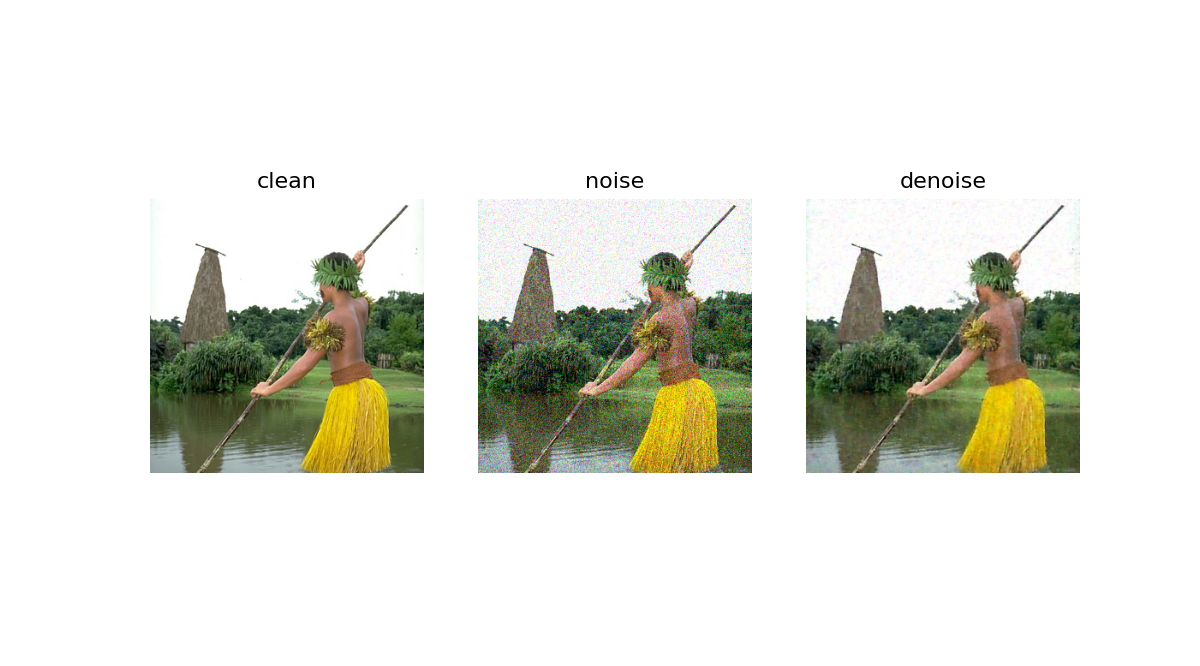

==> experiment  0


/usr/local/lib/python3.6/dist-packages/torch/quantization/observer.py:124: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."
/usr/local/lib/python3.6/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.6/dist-packages/torch/quantization/fx/quantization_patterns.py:444: UserWarning: dtype combination: (torch.float32, torch.

+---------------+--------------+--------+---------+---------+
| training      | quantization |   time |     mse |    ssim |
+---------------+--------------+--------+---------+---------+
| NA (origin)   | NA           |     NA | 0.00000 | 1.00000 |
| NA (noisy)    | NA           |     NA | 0.01093 | 0.48157 |
| standard      | none         | 100.00 | 0.00158 | 0.87032 |
| standard      | fx_static    |  69.72 | 0.00160 | 0.86841 |
| standard      | fx_dynamic   | 105.88 | 0.00158 | 0.87032 |
| QAT           | none         |  92.25 | 0.00140 | 0.88876 |
| QAT           | fx_static    |  61.35 | 0.00142 | 0.88710 |
| QAT           | fx_dynamic   |  92.21 | 0.00140 | 0.88876 |
| QAT_fc_static | fx_static    |  70.19 | 0.00428 | 0.68093 |
+---------------+--------------+--------+---------+---------+
==> experiment  1
+---------------+--------------+--------+---------+---------+
| training      | quantization |   time |     mse |    ssim |
+---------------+--------------+--------+---------+-

In [12]:
experiment_mean(img_set,10,False, True)

The experiment clearly showed the significant processing time improvement without much of the quality degradation using all variants of fx_static quantization. Suprisingly, Quantization Aware Training did not produce superior results over fx_static method, and in some cases the quality were reduced. It is possible that QAT will depend on the type of the data and with different dataset or algorithm will produce significantly better results. That assumption needs to be explored. The field is still very new. The project used PyTorch latest quantization techniques and software, some of which is still in pre-release. PyTorch quantization support only x86 and ARM architecures. x86 backend was used in the project.

The testing was done with one original image and and one noisy deriviated image. The time fluctuation between experiments can be attributed to the compute infrastructure and cluster resources. The summary values appeard to be  consistent over multiple experement runs performed.

10 Images Test

In [ ]:
x = 10
for i in range(x):
    img_set = test_set[i]
    print(("Experiment {}").format(i))
    experiment_mean(img_set,10,False, True)